# Predicción de la demanda

## Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split

## Analisis y exploración de los datos

### Dataset de caracteristicas: features.csv

In [2]:
features_df = pd.read_csv('../dataset/features.csv')

# Mostrar las primeras filas del dataset
print(features_df.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  


In [8]:
print(features_df.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


Columnas del dataset

* Store: Número de la tienda a la que pertenecen los datos.
* Date: Fecha en la que se registraron los datos.
* Temperature: Temperatura promedio en la región de la tienda (en grados Fahrenheit).
* Fuel_Price: Precio del combustible en la región de la tienda.
* MarkDown1 - MarkDown5: Descuentos promocionales aplicados a lo largo del tiempo. Pueden ser valores NaN si no hubo descuentos en ese período. 
* CPI (Consumer Price Index): Índice de Precios al Consumidor, que mide la inflación en la región de la tienda.
* Unemployment: Tasa de desempleo en la región de la tienda.
* IsHoliday: Indica si la fecha corresponde a un día festivo (True) o no (False).

Este dataset proporciona información sobre factores externos que pueden influir en las ventas, como la temperatura, los precios del combustible, la inflación y la tasa de desempleo.

In [9]:
# Variables y sus tipos
print(features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None


In [10]:
# Estadisticas de las variables
print(features_df.describe())

             Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.980000  104519.540000   

           MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment  
count    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000  
mean     1760.100180   3292.935886    4132.216422   172.460809      7.826821  
std     11276.462208   6792.329861   13086.690278    39.7383

In [3]:
# Ver valores nulos
print(features_df.isnull().sum())

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [3]:
# Número de filas antes de eliminar
num_rows_before = features_df.shape[0]

# Eliminar filas con datos NaN
features_df_cleaned = features_df.dropna()

# Número de filas después de eliminar
num_rows_after = features_df_cleaned.shape[0]

# Mostrar la cantidad de filas antes y después
print(f"Número de filas antes de eliminar: {num_rows_before}")
print(f"Número de filas después de eliminar: {num_rows_after}")

Número de filas antes de eliminar: 8190
Número de filas después de eliminar: 2069


In [5]:
print(features_df_cleaned.head())

    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
92      1  2011-11-11        59.11       3.297   10382.90    6115.67   
93      1  2011-11-18        62.25       3.308    6074.12     254.39   
94      1  2011-11-25        60.14       3.236     410.31      98.00   
95      1  2011-12-02        48.91       3.172    5629.51      68.00   
96      1  2011-12-09        43.93       3.158    4640.65      19.00   

    MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
92     215.07    2406.62    6551.42  217.998085         7.866      False  
93      51.98     427.39    5988.57  218.220509         7.866      False  
94   55805.51       8.00     554.92  218.467621         7.866       True  
95    1398.11    2084.64   20475.32  218.714733         7.866      False  
96     105.02    3639.42   14461.82  218.961846         7.866      False  


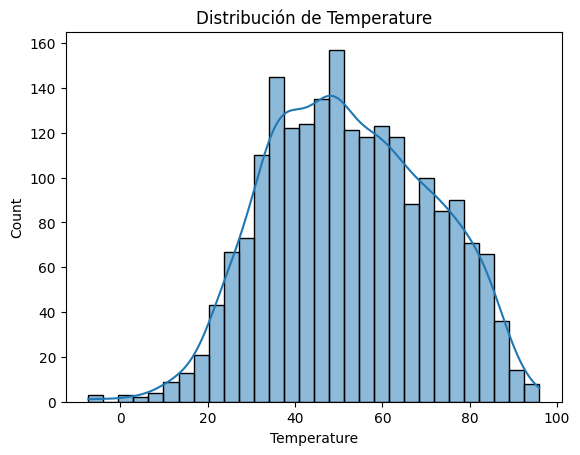

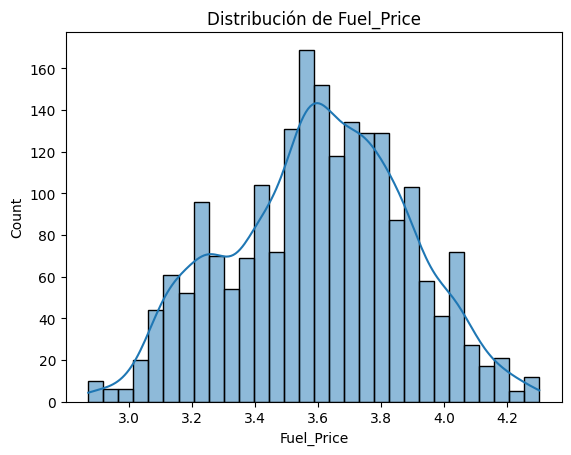

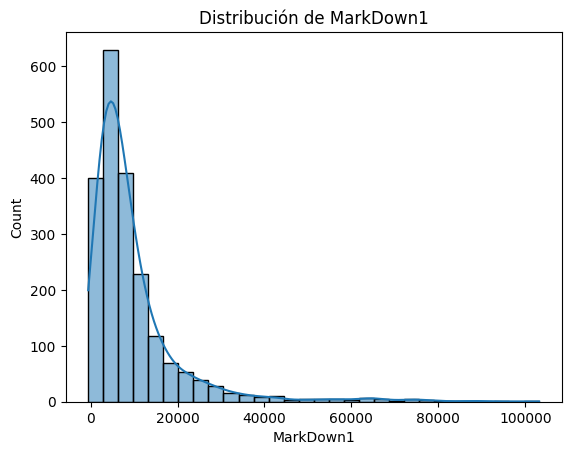

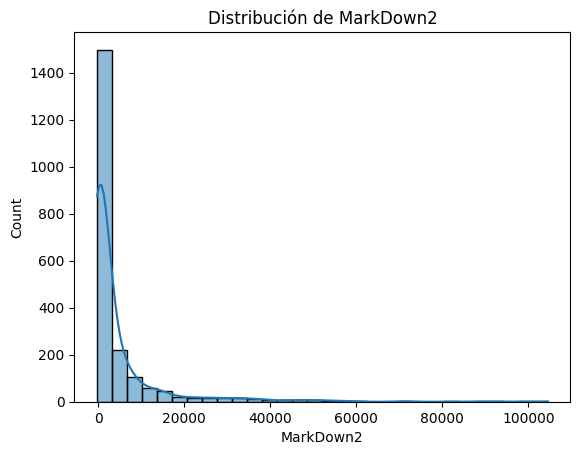

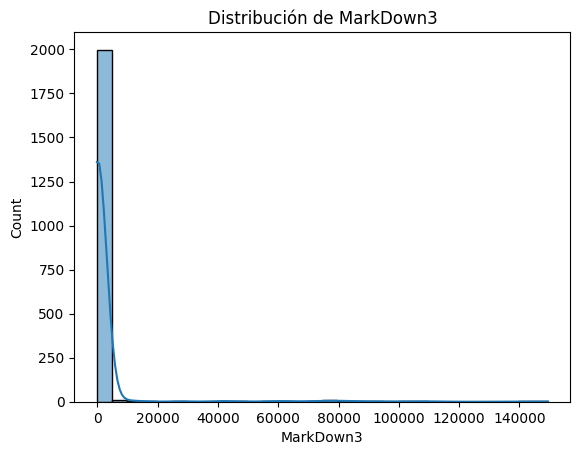

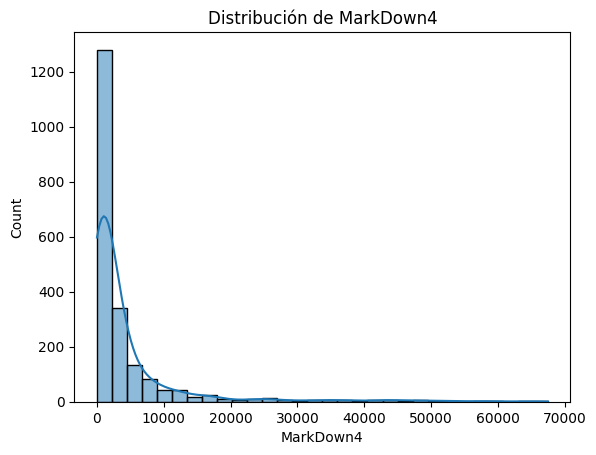

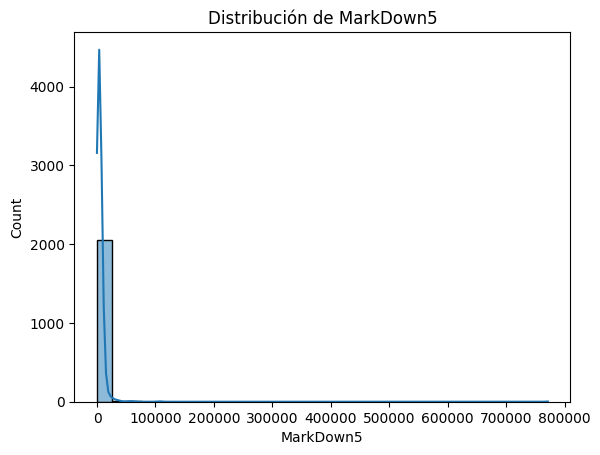

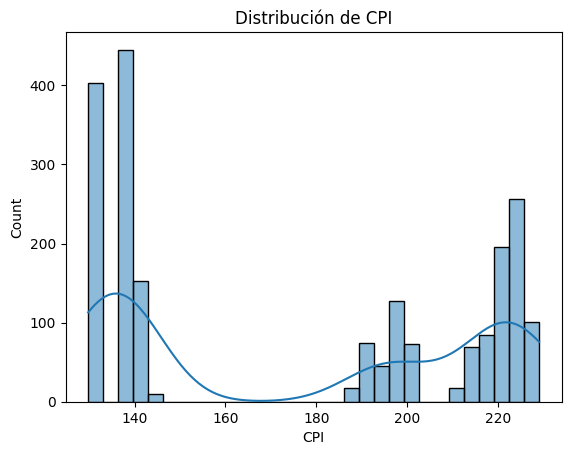

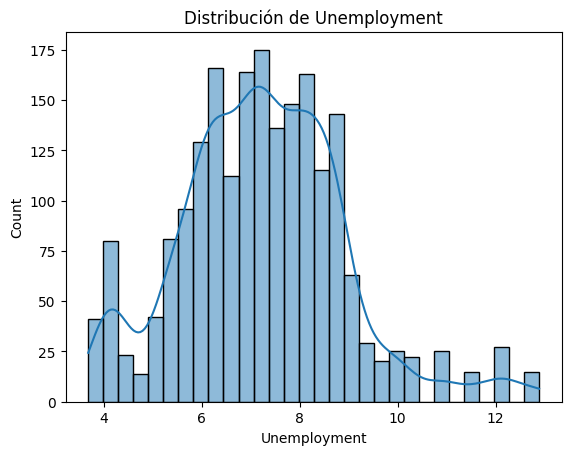

In [14]:
for i in features_df_cleaned.columns:
    # Histograma de una variable, por ejemplo, Temperature
    if (i=="Store" or i=="Date" or i=="IsHoliday"):
        continue
    sns.histplot(features_df_cleaned[i], bins=30, kde=True)
    plt.title(f"Distribución de {i}")
    plt.show()

### Dataset de tiendas: store.csv

In [4]:
stores_df = pd.read_csv('../dataset/stores.csv')

# Mostrar las primeras filas del dataset
print(stores_df.head())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


In [16]:
print(stores_df.columns)

Index(['Store', 'Type', 'Size'], dtype='object')


In [17]:
stores_df.shape

(45, 3)

In [18]:
# Variables y sus tipos
print(stores_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


In [19]:
#Ver valores nulos
print(stores_df.isnull().sum())

Store    0
Type     0
Size     0
dtype: int64


In [20]:
# Estadisticas de las variables
print(stores_df.describe())

           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000


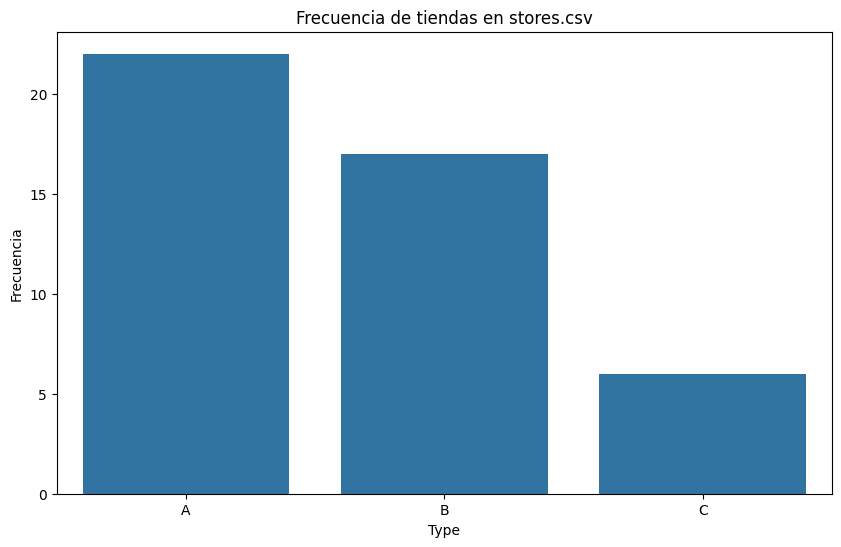

In [21]:
def plot_bar_chart_seaborn(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

# Llamar a la función para graficar
plot_bar_chart_seaborn(stores_df, 'Type', 'Frecuencia de tiendas en stores.csv')

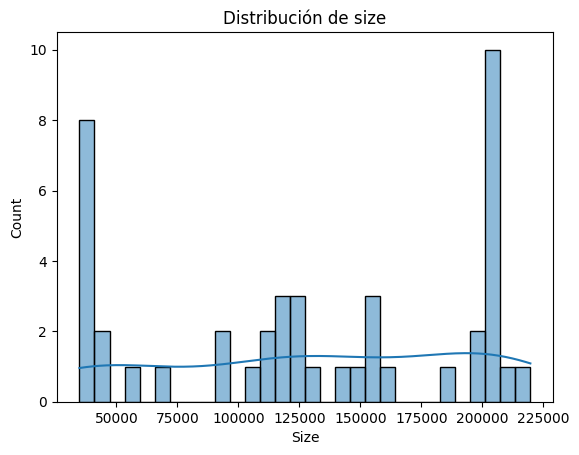

In [22]:
sns.histplot(stores_df['Size'], bins=30, kde=True)
plt.title(f"Distribución de size")
plt.show()

### Dataset de train: train.csv

In [5]:
train_df = pd.read_csv('../dataset/train.csv')

# Mostrar las primeras filas del dataset
print(train_df.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


In [24]:
print(train_df.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


In [25]:
train_df.shape

(421570, 5)

In [26]:
# Variables y sus tipos
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None


In [27]:
#Ver valores nulos
print(train_df.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [28]:
# Estadisticas de las variables
print(train_df.describe())

               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000


### Dataset de test: test.csv

In [50]:
test_df = pd.read_csv('../dataset/test.csv')

# Mostrar las primeras filas del dataset
print(test_df.head())

   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False


In [30]:
print(test_df.columns)

Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')


In [31]:
test_df.shape

(115064, 4)

In [32]:
# Variables y sus tipos
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB
None


In [33]:
#Ver valores nulos
print(test_df.isnull().sum())

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64


In [34]:
# Estadisticas de las variables
print(test_df.describe())

               Store           Dept
count  115064.000000  115064.000000
mean       22.238207      44.339524
std        12.809930      30.656410
min         1.000000       1.000000
25%        11.000000      18.000000
50%        22.000000      37.000000
75%        33.000000      74.000000
max        45.000000      99.000000


## Preprocesamiento

### Fusión de datasets

In [7]:
def merge_datasets(featured_df, stores_df, train_df):
    # Merge stores con featured
    merged_df = pd.merge(featured_df, stores_df, on='Store', how='left')
    # Merge con train
    final_df = pd.merge(merged_df, train_df, on=['Store', 'Date', 'IsHoliday'], how='right')
    return final_df

In [114]:
merged_df = merge_datasets(features_df_cleaned, stores_df, train_df)

In [51]:
predicted_df = merge_datasets(features_df_cleaned, stores_df, test_df)

In [9]:
print(merged_df.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales'],
      dtype='object')


In [118]:
print(merged_df.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05          NaN         NaN        NaN        NaN   
1      1  2010-02-12          NaN         NaN        NaN        NaN   
2      1  2010-02-19          NaN         NaN        NaN        NaN   
3      1  2010-02-26          NaN         NaN        NaN        NaN   
4      1  2010-03-05          NaN         NaN        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday Type  Size  \
0        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
1        NaN        NaN        NaN  NaN           NaN       True  NaN   NaN   
2        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
3        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   
4        NaN        NaN        NaN  NaN           NaN      False  NaN   NaN   

   Dept  Weekly_Sales  
0     1      24924.50  
1     1      46039.49  
2     1      41595.55  
3 

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   97056 non-null   float64
 3   Fuel_Price    97056 non-null   float64
 4   MarkDown1     97056 non-null   float64
 5   MarkDown2     97056 non-null   float64
 6   MarkDown3     97056 non-null   float64
 7   MarkDown4     97056 non-null   float64
 8   MarkDown5     97056 non-null   float64
 9   CPI           97056 non-null   float64
 10  Unemployment  97056 non-null   float64
 11  IsHoliday     421570 non-null  bool   
 12  Type          97056 non-null   object 
 13  Size          97056 non-null   float64
 14  Dept          421570 non-null  int64  
 15  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(11), int64(2), object(2)
memory usage: 48.6+ MB


In [13]:
#Ver valores nulos
print(merged_df.isnull().sum())

Store                0
Date                 0
Temperature     324514
Fuel_Price      324514
MarkDown1       324514
MarkDown2       324514
MarkDown3       324514
MarkDown4       324514
MarkDown5       324514
CPI             324514
Unemployment    324514
IsHoliday            0
Type            324514
Size            324514
Dept                 0
Weekly_Sales         0
dtype: int64


In [40]:
merged_df.shape

(421570, 16)

In [119]:
# Cargar datos (suponiendo que ya tienes el dataframe merged_df)
merged_df['Date'] = pd.to_datetime(merged_df['Date'])  # Convertir a datetime
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'Date'])  # Ordenar por fecha

# Manejo de valores nulos
cols_to_fill = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
merged_df[cols_to_fill] = merged_df[cols_to_fill].interpolate(method='linear')  # Interpolación
merged_df.bfill(inplace=True)  # Rellenar valores extremos con backward fill

# Codificación de variables categóricas
le = LabelEncoder()
merged_df['Type'] = le.fit_transform(merged_df['Type'].astype(str))
merged_df['IsHoliday'] = merged_df['IsHoliday'].astype(int)

# Normalización de datos
scaler = MinMaxScaler()
numeric_cols = cols_to_fill + ['Weekly_Sales']
merged_df[numeric_cols] = scaler.fit_transform(merged_df[numeric_cols])

# División del dataset en Train (70%), Validation (15%), Test (15%)
train_size = 0.7
val_size = 0.15
test_size = 0.15

df_train, df_temp = train_test_split(merged_df, train_size=train_size, shuffle=False)
df_val, df_test = train_test_split(df_temp, test_size=test_size/(val_size + test_size), shuffle=False)

print("Tamaño de los conjuntos de datos:")
print(f"Train: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

Tamaño de los conjuntos de datos:
Train: (295099, 16)
Validation: (63235, 16)
Test: (63236, 16)


In [21]:
print(merged_df.isnull().sum())

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
Dept            0
Weekly_Sales    0
dtype: int64


In [22]:
print(merged_df.head())

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05     0.583946    0.209449   0.116803     0.0609   0.001724   
1      1 2010-02-12     0.583946    0.209449   0.116803     0.0609   0.001724   
2      1 2010-02-19     0.583946    0.209449   0.116803     0.0609   0.001724   
3      1 2010-02-26     0.583946    0.209449   0.116803     0.0609   0.001724   
4      1 2010-03-05     0.583946    0.209449   0.116803     0.0609   0.001724   

   MarkDown4  MarkDown5       CPI  Unemployment  IsHoliday  Type      Size  \
0    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
1    0.03566   0.058891  0.907027      0.429933          1     0  0.630267   
2    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
3    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   
4    0.03566   0.058891  0.907027      0.429933          0     0  0.630267   

   Dept  Weekly_Sales  
0     1      0.04285

In [11]:
# Crear secuencias de tiempo
def create_sequences(data, feature_cols, target_col, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size, :-1])  # Excluir Weekly_Sales
        labels.append(data[i + window_size, target_col])
    return np.array(sequences), np.array(labels)

In [ ]:
window_size = 30
features = ['Temperature', 'Fuel_Price', 'MarkDown1', 
            'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
            'CPI', 'Unemployment', 'Size', 'IsHoliday']

X_train, y_train = create_sequences(df_train[features + ['Weekly_Sales']].values, features, -1, window_size)
X_val, y_val = create_sequences(df_val[features + ['Weekly_Sales']].values, features, -1, window_size)
X_test, y_test = create_sequences(df_test[features + ['Weekly_Sales']].values, features, -1, window_size)

# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\2206c\OneDrive\Documentos\A.N.N-applications\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
import os

ruta_actual = os.getcwd()  # Obtiene la ruta actual
ruta_archivo = os.path.join(ruta_actual, "merged_df.csv")

merged_df.to_csv(ruta_archivo, index=False)

print(f"Archivo guardado en: {ruta_archivo}")

Archivo guardado en: c:\Users\2206c\OneDrive\Documentos\A.N.N-applications\demand_prediction\notebooks\merged_df.csv


In [25]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 227s 24ms/step - loss: 0.0014 - mae: 0.0241 - val_loss: 7.2642e-04 - val_mae: 0.0182
Epoch 2/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 226s 24ms/step - loss: 0.0011 - mae: 0.0217 - val_loss: 7.4414e-04 - val_mae: 0.0201
Epoch 3/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 226s 25ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 7.8610e-04 - val_mae: 0.0212
Epoch 4/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 242s 26ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 7.7074e-04 - val_mae: 0.0195
Epoch 5/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 262s 28ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 7.2959e-04 - val_mae: 0.0188
Epoch 6/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 278s 30ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 7.8154e-04 - val_mae: 0.0198
Epoch 7/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 327s 35ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 7.7016e-04 - val_mae: 0.0202
Epoch 8/20
9221/9221 ━━━━━━━━━━━━━━━━━━━━ 340s 37ms/step - loss: 0.0011 - mae: 0.0215 - val_loss: 7.9663e-04 - 

In [26]:
model.save("lstm_model.h5")

In [27]:
# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, MAE: {mae}')

1976/1976 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 9.4702e-04 - mae: 0.0241
Loss: 0.0008960263803601265, MAE: 0.023553958162665367


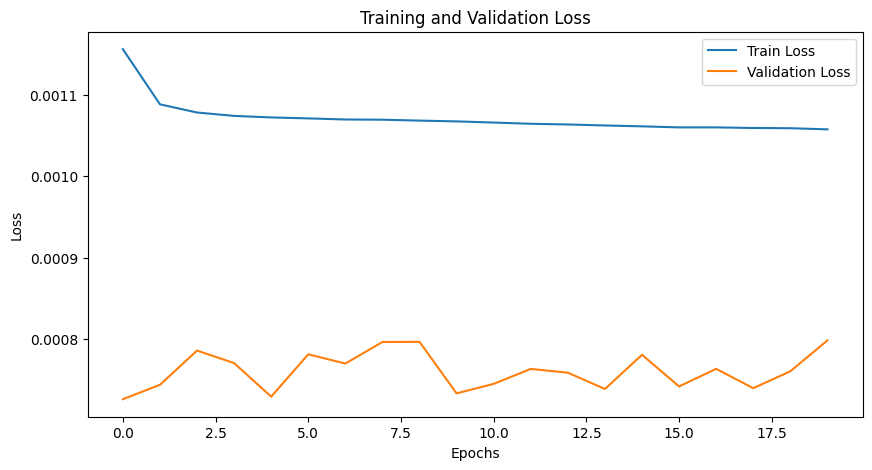

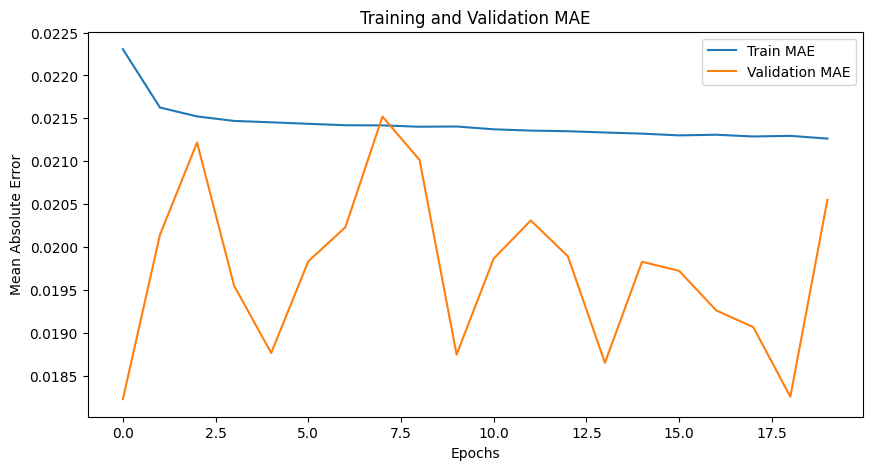

In [ ]:
# Graficar métricas
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

In [31]:
# Obtener predicciones
y_pred = model.predict(X_test)

1976/1976 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step


In [34]:
scaler_sales = MinMaxScaler()
merged_df['Weekly_Sales'] = scaler_sales.fit_transform(merged_df[['Weekly_Sales']])

In [ ]:
y_pred_actual = scaler_sales.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler_sales.inverse_transform(y_test.reshape(-1, 1))

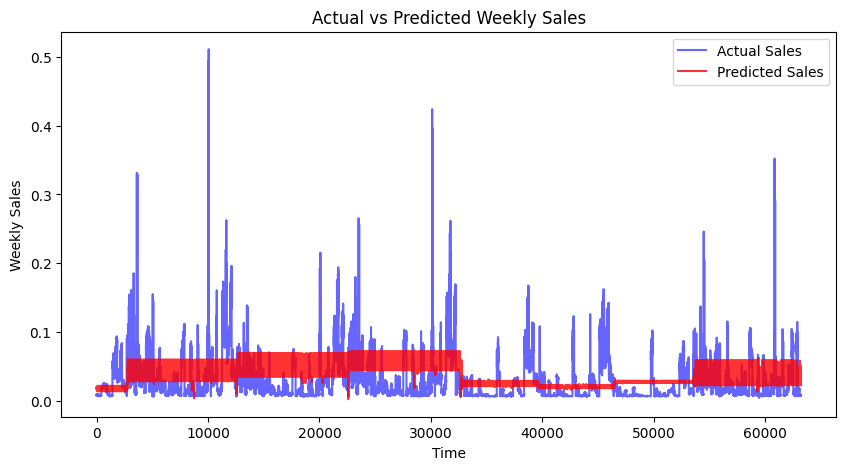

In [105]:
# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Sales', color='blue', alpha=0.6)
plt.plot(y_pred_actual, label='Predicted Sales', color='red', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.show()

In [52]:
predicted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Date          115064 non-null  object 
 2   Temperature   46491 non-null   float64
 3   Fuel_Price    46491 non-null   float64
 4   MarkDown1     46491 non-null   float64
 5   MarkDown2     46491 non-null   float64
 6   MarkDown3     46491 non-null   float64
 7   MarkDown4     46491 non-null   float64
 8   MarkDown5     46491 non-null   float64
 9   CPI           46491 non-null   float64
 10  Unemployment  46491 non-null   float64
 11  IsHoliday     115064 non-null  bool   
 12  Type          46491 non-null   object 
 13  Size          46491 non-null   float64
 14  Dept          115064 non-null  int64  
dtypes: bool(1), float64(10), int64(2), object(2)
memory usage: 12.4+ MB


In [53]:
#Ver valores nulos
print(predicted_df.isnull().sum())

Store               0
Date                0
Temperature     68573
Fuel_Price      68573
MarkDown1       68573
MarkDown2       68573
MarkDown3       68573
MarkDown4       68573
MarkDown5       68573
CPI             68573
Unemployment    68573
IsHoliday           0
Type            68573
Size            68573
Dept                0
dtype: int64


In [54]:
predicted_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept
0,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315.0,1
1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False,A,151315.0,1
2,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False,A,151315.0,1
3,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True,A,151315.0,1
4,1,2012-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,1


In [57]:
# Cargar datos
predicted_df['Date'] = pd.to_datetime(predicted_df['Date'])  # Convertir a datetime
predicted_df = predicted_df.sort_values(by=['Store', 'Dept', 'Date'])  # Ordenar por fecha

# Manejo de valores nulos
cols_to_fill = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
predicted_df[cols_to_fill] = predicted_df[cols_to_fill].interpolate(method='linear')  # Interpolación
predicted_df.bfill(inplace=True)  # Rellenar valores extremos con backward fill

# Codificación de variables categóricas
le = LabelEncoder()
predicted_df['Type'] = le.fit_transform(predicted_df['Type'].astype(str))
predicted_df['IsHoliday'] = predicted_df['IsHoliday'].astype(int)

# Normalización de datos
scaler = MinMaxScaler()
numeric_cols = cols_to_fill
predicted_df[numeric_cols] = scaler.fit_transform(predicted_df[numeric_cols])

predicted_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept
0,1,2012-11-02,0.792732,0.410215,0.070655,0.072893,0.001537,0.055692,0.003788,0.943588,0.443438,0,0,0.630267,1
1,1,2012-11-09,0.867688,0.352753,0.115521,0.047907,0.001467,0.071101,0.008215,0.943778,0.443438,0,0,0.630267,1
2,1,2012-11-16,0.762345,0.303272,0.098894,0.004610,0.001891,0.017329,0.008810,0.944101,0.443438,0,0,0.630267,1
3,1,2012-11-23,0.804254,0.270551,0.013952,0.000561,0.501726,0.003200,0.000633,0.944603,0.443438,1,0,0.630267,1
4,1,2012-11-30,0.775285,0.254110,0.036653,0.104898,0.401854,0.002786,0.000868,0.945418,0.443438,0,0,0.630267,1


In [103]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError  # Importar MSE manualmente

ruta_actual = os.getcwd()  # Obtiene la ruta actual
ruta = os.path.join(ruta_actual,"lstm_model.h5")
print(ruta)
model = load_model("lstm_model.h5", custom_objects={"mse": MeanSquaredError()})
print("Modelo cargado correctamente ✅")

c:\Users\2206c\OneDrive\Documentos\A.N.N-applications\demand_prediction\notebooks\lstm_model.h5
Modelo cargado correctamente ✅


In [75]:
print("Forma esperada por el modelo:", model.input_shape)
print("Forma de los datos de entrada:", np.array(predicted_df[features]).shape)


Forma esperada por el modelo: (None, 30, 11)
Forma de los datos de entrada: (115064, 11)


In [76]:
# Convertir los datos a un array de NumPy
X_pred = np.array(predicted_df[features])

# Crear las secuencias de 30 pasos
sequence_length = 30
num_samples = X_pred.shape[0] - sequence_length + 1  # Asegurar que encajen

X_pred_sequences = np.array([X_pred[i:i+sequence_length] for i in range(num_samples)])

# Verificar la nueva forma
print("Nueva forma de X_pred:", X_pred_sequences.shape)  # Debe ser (num_samples, 30, 11)

# Hacer la predicción
predictions = model.predict(X_pred_sequences)

# Guardar las predicciones en el DataFrame (ajustar si es necesario)
predicted_df.loc[sequence_length-1:, "Weekly_Sales"] = predictions.flatten()


Nueva forma de X_pred: (115035, 30, 11)
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step


In [84]:
print("X_pred_sequences shape:", X_pred_sequences.shape)
print("Predictions shape:", predictions.shape)


X_pred_sequences shape: (115035, 30, 11)
Predictions shape: (115035, 1)


In [77]:
# Asegurar que la columna de fecha sea de tipo datetime
predicted_df["Date"] = pd.to_datetime(predicted_df["Date"])

# Obtener la fecha mínima y máxima
min_date = predicted_df["Date"].min()
max_date = predicted_df["Date"].max()

print(f"📅 Fecha mínima: {min_date}")
print(f"📅 Fecha máxima: {max_date}")

📅 Fecha mínima: 2012-11-02 00:00:00
📅 Fecha máxima: 2013-07-26 00:00:00


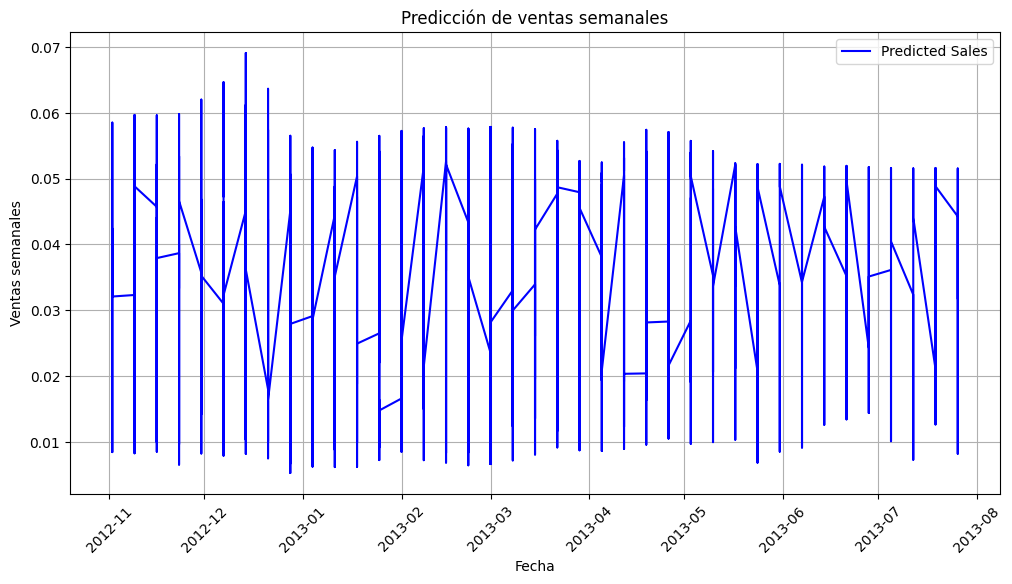

In [78]:
import matplotlib.pyplot as plt

# Ordenar por fecha para una mejor visualización
predicted_df = predicted_df.sort_values("Date")

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(predicted_df["Date"], predicted_df["Weekly_Sales"], label="Predicted Sales", color="blue")

# Configuración del gráfico
plt.xlabel("Fecha")
plt.ylabel("Ventas semanales")
plt.title("Predicción de ventas semanales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Mostrar gráfico
plt.show()


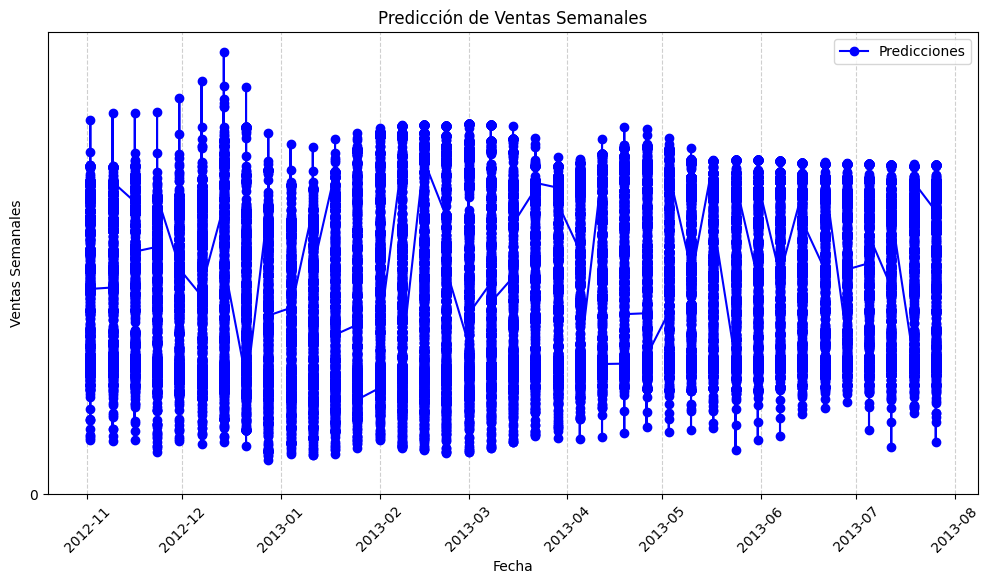

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asegurar que la columna Date es de tipo datetime
predicted_df["Date"] = pd.to_datetime(predicted_df["Date"])

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar predicciones en azul
plt.plot(predicted_df["Date"], predicted_df["Weekly_Sales"], label="Predicciones", color="blue", marker="o", linestyle="-")

# Configuración del gráfico
plt.xlabel("Fecha")
plt.ylabel("Ventas Semanales")
plt.title("Predicción de Ventas Semanales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)  # Rotar fechas para mejor visualización

# Ajustar el eje Y para que muestre números enteros
plt.yticks(np.arange(0, predicted_df["Weekly_Sales"].max() + 1, step=5))  # Ajusta el step según el rango de valores

# Mostrar gráfico
plt.show()


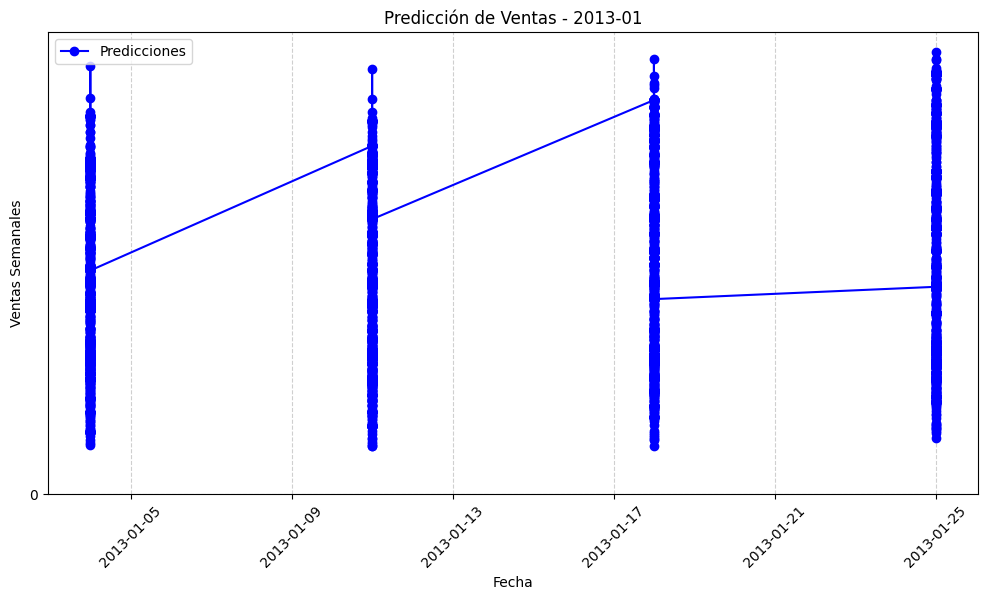

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asegurar que la columna Date es de tipo datetime
predicted_df["Date"] = pd.to_datetime(predicted_df["Date"])

# Filtrar solo el mes de enero de 2013
mes_especifico = "2013-01"
df_filtrado = predicted_df[predicted_df["Date"].dt.strftime("%Y-%m") == mes_especifico]

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar predicciones en azul
plt.plot(df_filtrado["Date"], df_filtrado["Weekly_Sales"], label="Predicciones", color="blue", marker="o", linestyle="-")

# Configuración del gráfico
plt.xlabel("Fecha")
plt.ylabel("Ventas Semanales")
plt.title(f"Predicción de Ventas - {mes_especifico}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)  # Rotar fechas para mejor visualización

# Ajustar el eje Y para que muestre números enteros
plt.yticks(np.arange(0, df_filtrado["Weekly_Sales"].max() + 1, step=5))  # Ajusta el step según los datos

# Mostrar gráfico
plt.show()


In [62]:
print(predicted_df[features].isnull().sum())


Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Size            0
IsHoliday       0
dtype: int64


In [63]:
print(predicted_df[features].dtypes)


Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Size            float64
IsHoliday         int32
dtype: object


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

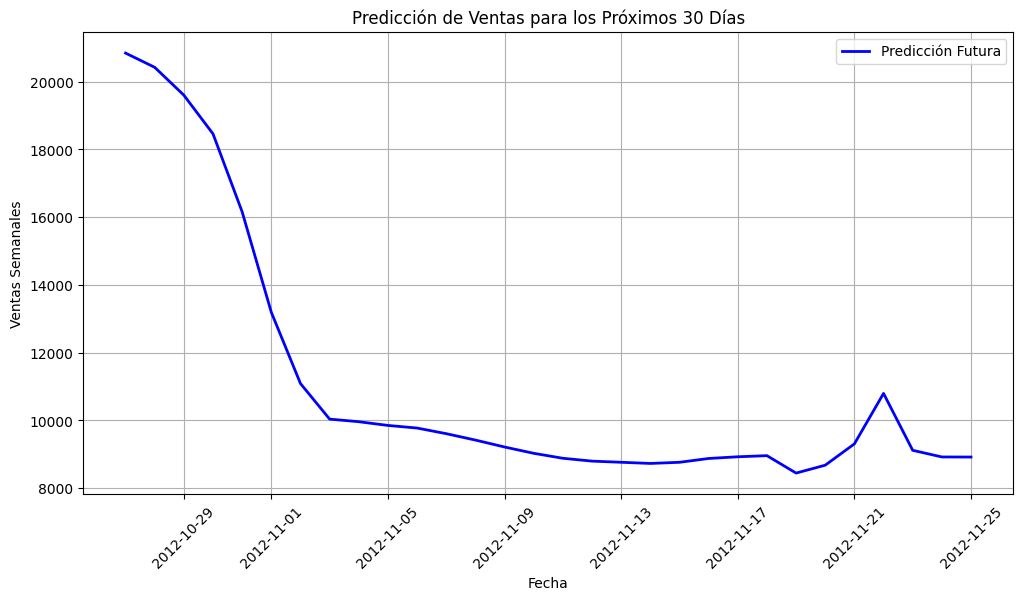

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Longitud de la secuencia usada en el modelo
sequence_length = 30  

# Obtener la última secuencia conocida
X_last_sequence = np.array(merged_df[features].iloc[-sequence_length:])  # Últimos 30 días
X_last_sequence = X_last_sequence.reshape(1, sequence_length, -1)  # Asegurar forma correcta

# Lista para almacenar predicciones futuras
future_predictions = []

# Generar predicciones para los próximos 30 días
for _ in range(30):  
    # Predecir el próximo valor
    next_prediction = model.predict(X_last_sequence)[0, 0]  
    future_predictions.append(next_prediction)

    # Desplazar la secuencia e insertar la nueva predicción
    next_input = np.roll(X_last_sequence, shift=-1, axis=1)  # Desplazar izquierda
    next_input[0, -1, 0] = next_prediction  # Insertar la nueva predicción en la última posición

    X_last_sequence = next_input  # Actualizar la secuencia para la siguiente iteración

print(future_predictions)
# Desnormalizar predicciones si se usó normalización en el entrenamiento
try:
    # Valores mínimo y máximo originales antes de la normalización
    min_sales = -4988.94
    max_sales = 693099.36

    # Convertir las predicciones normalizadas a su valor real
    future_predictions = np.array(future_predictions) * (max_sales - min_sales) + min_sales

except NameError:
    print("sales_scaler no definido. Las predicciones pueden estar normalizadas.")
    
print(future_predictions)
# Crear DataFrame con las fechas futuras
last_date = merged_df["Date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

future_df = pd.DataFrame({"Date": future_dates, "Predicted_Weekly_Sales": future_predictions})

# Graficar solo la predicción futura
plt.figure(figsize=(12,6))
plt.plot(future_df["Date"], future_df["Predicted_Weekly_Sales"], label="Predicción Futura", color="blue", linewidth=2)

plt.xlabel("Fecha")
plt.ylabel("Ventas Semanales")
plt.title("Predicción de Ventas para los Próximos 30 Días")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.show()


In [120]:
print(merged_df[features].dtypes)


Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Size            float64
IsHoliday         int32
dtype: object


In [ ]:
# Valores mínimo y máximo originales antes de la normalización
min_sales = -4988.94
max_sales = 693099.36

# Convertir las predicciones normalizadas a su valor real
future_predictions = np.array(future_predictions) * (max_sales - min_sales) + min_sales


count    421570.000000
mean          0.030039
std           0.032533
min           0.000000
25%           0.010126
50%           0.018051
75%           0.036091
max           1.000000
Name: Weekly_Sales, dtype: float64
[0.] [1.]
